In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import Image  
from sklearn.tree import export_graphviz
%matplotlib inline
import warnings;
warnings.filterwarnings('ignore');
from io import StringIO


### helper method

In [2]:
def gather_metrics(method, y_test, y_pred, lst_quality, axes = None) :
    accuracy_score = metrics.accuracy_score(y_test,y_pred)
    dict_metrics = metrics.classification_report(y_test, y_pred, output_dict=True)
    
    if method not in (None, '') :
        if method in test_output['Method'] :
            index = test_output['Method'].index(method)
            test_output['Accuracy score'][index] = accuracy_score

            for quality in lst_quality :
                if quality in dict_metrics :
                    test_precision[quality][index] = dict_metrics[quality]['precision']
                    test_recall[quality][index] = dict_metrics[quality]['recall']
                    test_f1score[quality][index] = dict_metrics[quality]['f1-score']
                else :
                    test_precision[quality][index] = 0
                    test_recall[quality][index] = 0
                    test_f1score[quality][index] = 0
        else :
            test_output['Method'].append(method)
            test_output['Accuracy score'].append(accuracy_score)

            test_precision['Method'].append(method)
            test_recall['Method'].append(method)
            test_f1score['Method'].append(method)
            for quality in lst_quality :
                if quality in dict_metrics :
                    test_precision[quality].append(dict_metrics[quality]['precision'])
                    test_recall[quality].append(dict_metrics[quality]['recall'])
                    test_f1score[quality].append(dict_metrics[quality]['f1-score'])
                else :
                    test_precision[quality].append(0)
                    test_recall[quality].append(0)
                    test_f1score[quality].append(0)

    print('Accuracy score : %.4f'%accuracy_score)

    display(pd.DataFrame(dict_metrics))

    if axes == None :
        print('\nConfusion matrix')
        sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, fmt='d', cbar=False, cmap='Blues', yticklabels=lst_quality, xticklabels=lst_quality)
    else :
        axes.set_title('Confusion matrix')
        sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, fmt='d', cbar=False, cmap='Blues', ax = axes, yticklabels=lst_quality, xticklabels=lst_quality)

## i. Data collection, preprocessing and EDA

In [3]:
dataset = pd.read_csv('QualityPrediction.csv')
lst_cols = list(dataset.columns)
lst_cols.remove('quality')

print('Inspect first few rows to check the pattern of data')
dataset.head(10)

Inspect first few rows to check the pattern of data


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [4]:
print('Check data type of dataset')
dataset.info()

Check data type of dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


### Check for empy values in all columns and unique values alongwith count in quality

In [5]:
print('Check for empty values')
print(dataset.isnull().sum())

print('\nCheck for unique values in quality')
lst_quality = [str(x) for x in np.sort(dataset['quality'].unique())]
print(lst_quality)

print('\nCheck count of each value in quality')
print(dataset.groupby(['quality'])['quality'].count())

Check for empty values
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Check for unique values in quality
['3', '4', '5', '6', '7', '8']

Check count of each value in quality
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64


### Distribution of each independent variable to check skewness 

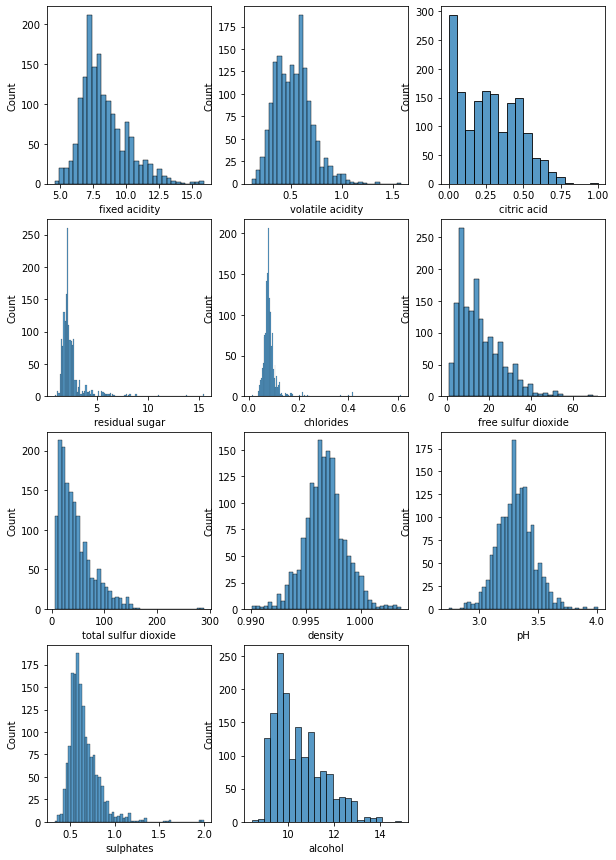

In [6]:
fig, axes = plt.subplots(4, 3, figsize=(10, 15))
axes= axes.ravel()
fig.delaxes(axes[11])
counter = 0
for col in lst_cols :
    sns.histplot(data=dataset, x=col, ax = axes[counter])
    counter+=1

### Correlation matrix of every variable with each other

<AxesSubplot:>

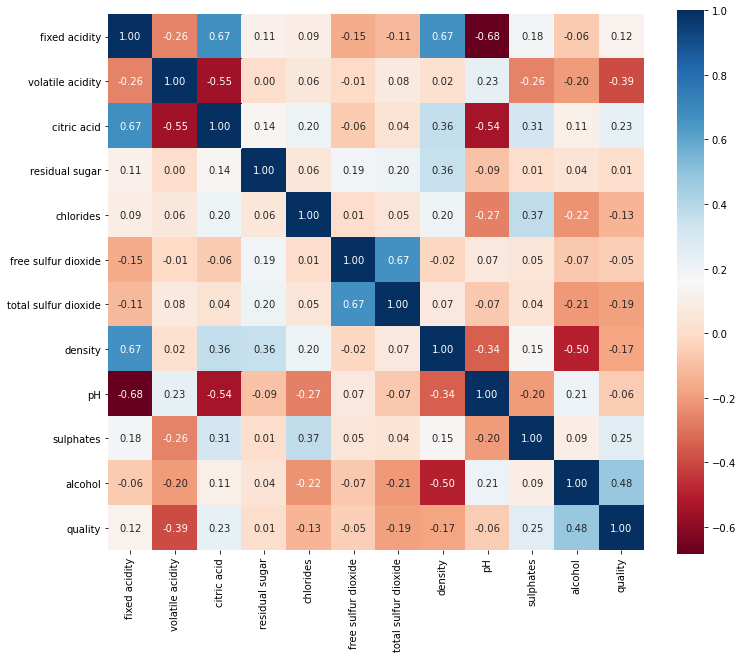

In [35]:
plt.figure(figsize=(12,10))
sns.heatmap(dataset.corr(), cmap = 'RdBu', cbar=True, annot=True, square=True, fmt='.2f')

### Define X,Y and test output variable

In [9]:
X = dataset[lst_cols]
Y = dataset['quality']
test_output = {'Method' : [], 'Accuracy score' : []}
test_precision = {'Method' : []}
test_recall = {'Method' : []}
test_f1score = {'Method' : []}

for x in lst_quality :
    test_precision[x] = []
    test_recall[x] = []
    test_f1score[x] = []

### Detect Multicollinearity

In [10]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(lst_cols))]
vif_data

,feature,VIF
0,fixed acidity,74.452265
1,volatile acidity,17.060026
2,citric acid,9.183495
3,residual sugar,4.662992
4,chlorides,6.554877
5,free sulfur dioxide,6.442682
6,total sulfur dioxide,6.519699
7,density,1479.287209
8,pH,1070.967685
9,sulphates,21.590621


<p><p>

## ii. Training & evaluation of model alongwith paramter tuning

### a. Logistic regression

#### Logistic regression after removing outliers using z-score method

Before and after outlier removal count :  1599 1431
Accuracy score : 0.5838


,3,4,5,6,7,8,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.683544,0.527607,0.405405,0.0,0.583799,0.269426,0.550279
recall,0.0,0.0,0.724832,0.593103,0.326087,0.0,0.583799,0.274004,0.583799
f1-score,0.0,0.0,0.703583,0.558442,0.361446,0.0,0.583799,0.270578,0.565459
support,1.0,12.0,149.000000,145.000000,46.000000,5.0,0.583799,358.000000,358.000000



Confusion matrix


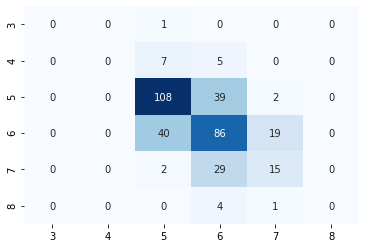

In [11]:
X_new = X.copy()
X_new['quality'] = dataset['quality']

for col in lst_cols :
    mean = X_new[col].mean()
    std = X_new[col].std()
    outliers_z = X_new[abs((X_new[col]-mean)/std) > 3]
    X_new.drop(outliers_z.index,axis=0,inplace=True)
print('Before and after outlier removal count : ', len(X), len(X_new))

X_new1 = X_new.drop('quality',axis=1)
Y_new1 = X_new['quality']

x_train,x_test,y_train,y_test=train_test_split(X_new1,Y_new1,test_size=0.25, random_state=50)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = LogisticRegression(random_state=0)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

gather_metrics('LR - outlier z-score', y_test, y_pred, lst_quality)

In [12]:
#### Logistic regression after removing outliers using IQR method

Before and after outlier removal count :  1599 1194
Accuracy score : 0.6020


,3,4,5,6,7,8,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.673913,0.528986,0.636364,0.0,0.602007,0.306544,0.588653
recall,0.0,0.0,0.732283,0.618644,0.318182,0.0,0.602007,0.278185,0.602007
f1-score,0.0,0.0,0.701887,0.570312,0.424242,0.0,0.602007,0.282740,0.585629
support,3.0,5.0,127.000000,118.000000,44.000000,2.0,0.602007,299.000000,299.000000



Confusion matrix


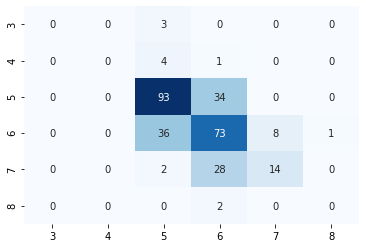

In [13]:
X_describe = X.describe()
X_new = X.copy()
X_new['quality'] = dataset['quality']

for col in lst_cols :
    Q1 = X_describe[col]["25%"]
    Q3 = X_describe[col]["75%"]
    IQR = Q3 - Q1
    outliers_iqr = X_new[(X_new[col] > Q3 + IQR * 1.5) | (X_new[col] < Q1 - IQR * 1.5)]
    X_new.drop(outliers_iqr.index,axis=0,inplace=True)
print('Before and after outlier removal count : ', len(X), len(X_new))

X_new1 = X_new.drop('quality',axis=1)
Y_new1 = X_new['quality']

x_train,x_test,y_train,y_test=train_test_split(X_new1,Y_new1,test_size=0.25, random_state=50)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = LogisticRegression(random_state=0)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

gather_metrics('LR - outlier IQR', y_test, y_pred, lst_quality)

### b. Decision tree & Random forest

In [14]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25, random_state=50)

dict_score = {'Depth' : [],'Gini Training Score':[],'Entropy Training Score':[],'Gini Testing Score':[],'Entropy Testing Score':[]}

for i in range(2,16) :
    dict_score['Depth'].append(i)
    
    model = DecisionTreeClassifier(random_state=1,max_depth=i)
    model.fit(x_train,y_train)
    
    dict_score['Gini Training Score'].append(model.score(x_train,y_train))
    dict_score['Gini Testing Score'].append(model.score(x_test,y_test))
    
    model = DecisionTreeClassifier(random_state=1,max_depth=i,criterion='entropy')
    model.fit(x_train,y_train)
    
    dict_score['Entropy Training Score'].append(model.score(x_train,y_train))
    dict_score['Entropy Testing Score'].append(model.score(x_test,y_test))

df_score = pd.DataFrame(dict_score)
df_score

,Depth,Gini Training Score,Entropy Training Score,Gini Testing Score,Entropy Testing Score
0,2,0.549625,0.546289,0.5525,0.5750
1,3,0.577148,0.552127,0.5350,0.5325
2,4,0.618849,0.583820,0.5525,0.5725
3,5,0.649708,0.643870,0.5350,0.5875
4,6,0.699750,0.706422,0.5475,0.6175
5,7,0.748123,0.741451,0.5800,0.6175
6,8,0.795663,0.790659,0.5800,0.5975
7,9,0.832360,0.849041,0.5850,0.5850
8,10,0.873228,0.898249,0.6125,0.6175
9,11,0.908257,0.940784,0.6375,0.6025


We can see that for depth 6-10 score is more stable so we need to find metrics for these three using both gini and entropy

### b.i. Decision tree depth 6-10 using gini

Depth : 6
Accuracy score : 0.5475


,3,4,5,6,7,8,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.697368,0.466063,0.588235,0.0,0.5475,0.291945,0.573820
recall,0.0,0.0,0.530000,0.715278,0.256410,0.0,0.5475,0.250281,0.547500
f1-score,0.0,0.0,0.602273,0.564384,0.357143,0.0,0.5475,0.253967,0.539136
support,3.0,10.0,200.000000,144.000000,39.000000,4.0,0.5475,400.000000,400.000000




Depth : 8
Accuracy score : 0.5800


,3,4,5,6,7,8,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.748387,0.495098,0.500000,0.0,0.58,0.290581,0.601179
recall,0.0,0.0,0.580000,0.701389,0.384615,0.0,0.58,0.277667,0.580000
f1-score,0.0,0.0,0.653521,0.580460,0.434783,0.0,0.58,0.278127,0.578117
support,3.0,10.0,200.000000,144.000000,39.000000,4.0,0.58,400.000000,400.000000




Depth : 10
Accuracy score : 0.5800


,3,4,5,6,7,8,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.748387,0.495098,0.500000,0.0,0.58,0.290581,0.601179
recall,0.0,0.0,0.580000,0.701389,0.384615,0.0,0.58,0.277667,0.580000
f1-score,0.0,0.0,0.653521,0.580460,0.434783,0.0,0.58,0.278127,0.578117
support,3.0,10.0,200.000000,144.000000,39.000000,4.0,0.58,400.000000,400.000000


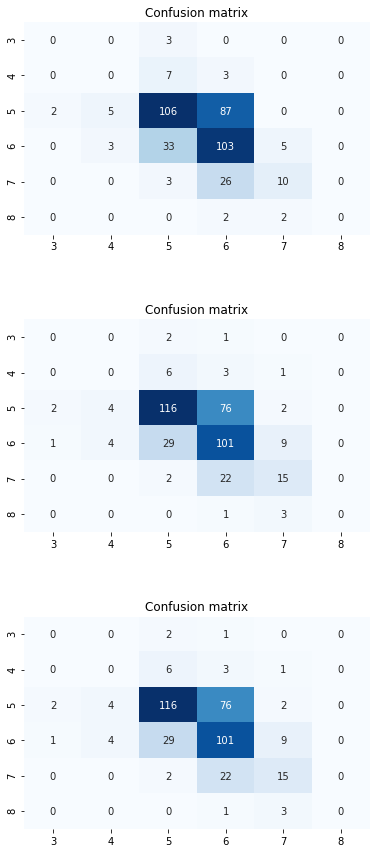

In [15]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25, random_state=50)

fig, axes = plt.subplots(3, 1, figsize=(6, 14))
axes = axes.ravel()

model = DecisionTreeClassifier(random_state=1,max_depth=6)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print('Depth : 6')
gather_metrics('', y_test, y_pred, lst_quality, axes[0])
print('\n')

print('Depth : 8')
model = DecisionTreeClassifier(random_state=1,max_depth=8)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
gather_metrics('', y_test, y_pred, lst_quality, axes[1])
print('\n')

print('Depth : 10')
model = DecisionTreeClassifier(random_state=1,max_depth=10)
model.fit(x_train,y_train)
gather_metrics('', y_test, y_pred, lst_quality, axes[2])
print('\n')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

<p></p>

### b.ii. Decision tree depth 6-10 using entropy

Depth : 6
Accuracy score : 0.6175


,3,4,5,6,7,8,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.705882,0.558621,0.357143,0.0,0.6175,0.270274,0.588866
recall,0.0,0.0,0.780000,0.562500,0.256410,0.0,0.6175,0.266485,0.617500
f1-score,0.0,0.0,0.741093,0.560554,0.298507,0.0,0.6175,0.266692,0.601450
support,3.0,10.0,200.000000,144.000000,39.000000,4.0,0.6175,400.000000,400.000000




Depth : 8
Accuracy score : 0.5975


,3,4,5,6,7,8,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.692308,0.539007,0.487179,0.0,0.5975,0.286416,0.587696
recall,0.0,0.0,0.720000,0.527778,0.487179,0.0,0.5975,0.289160,0.597500
f1-score,0.0,0.0,0.705882,0.533333,0.487179,0.0,0.5975,0.287733,0.592441
support,3.0,10.0,200.000000,144.000000,39.000000,4.0,0.5975,400.000000,400.000000




Depth : 10
Accuracy score : 0.6175


,3,4,5,6,7,8,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.720588,0.596899,0.488889,0.166667,0.6175,0.328841,0.624511
recall,0.0,0.0,0.735000,0.534722,0.564103,0.250000,0.6175,0.347304,0.617500
f1-score,0.0,0.0,0.727723,0.564103,0.523810,0.200000,0.6175,0.335939,0.620010
support,3.0,10.0,200.000000,144.000000,39.000000,4.000000,0.6175,400.000000,400.000000


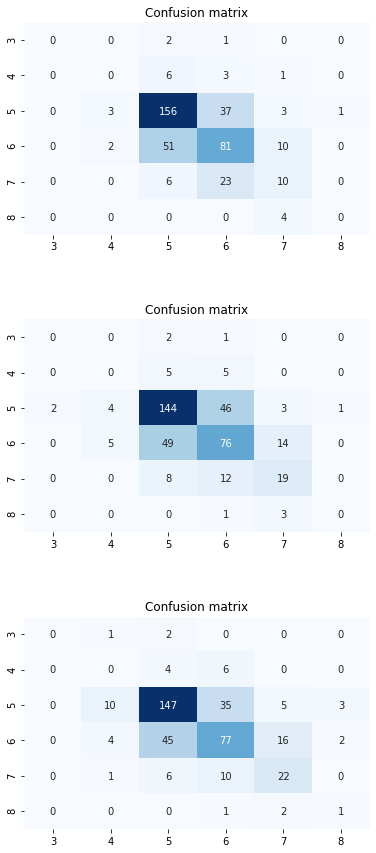

In [17]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25, random_state=50)

fig, axes = plt.subplots(3, 1, figsize=(6, 14))
axes = axes.ravel()

model = DecisionTreeClassifier(random_state=1,max_depth=6, criterion='entropy')
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print('Depth : 6')
gather_metrics('', y_test, y_pred, lst_quality, axes[0])
print('\n')


model = DecisionTreeClassifier(random_state=1,max_depth=8, criterion='entropy')
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print('Depth : 8')
gather_metrics('', y_test, y_pred, lst_quality, axes[1])
print('\n')

model = DecisionTreeClassifier(random_state=1,max_depth=10, criterion='entropy')
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print('Depth : 10')
gather_metrics('', y_test, y_pred, lst_quality, axes[2])
print('\n')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

### b.iii. Random forest

In [19]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25, random_state=50)

model_rf = RandomForestClassifier(random_state=30)

start = time.time()

param_dist = {
              'max_depth': [4, 6, 8, 10],
              'bootstrap': [True,False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy'],
              'max_leaf_nodes' : [256, 512]
             }

cv_rf = GridSearchCV(model_rf, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 8)

cv_rf.fit(x_train, y_train)
print('Best Parameters using grid search: \n', cv_rf.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': 256}
Time taken in grid search:  186.03


In [20]:
model_rf.set_params(criterion = 'gini',
                  max_features = 'auto', 
                  max_depth = 10,
                  bootstrap = True,
                  max_leaf_nodes = 256,
                  warm_start=True,
                  oob_score=True)

RandomForestClassifier(max_depth=10, max_leaf_nodes=256, oob_score=True,
                       random_state=30, warm_start=True)

In [21]:
min_estimators = 200
max_estimators = 1200

error_rate = {}

for i in range(min_estimators, max_estimators + 1, 5):
    model_rf.set_params(n_estimators=i)
    model_rf.fit(x_train, y_train)

    oob_error = 1 - model_rf.oob_score_
    error_rate[i] = oob_error
oob_series = pd.Series(error_rate)

Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 50 to 1000 trees)')

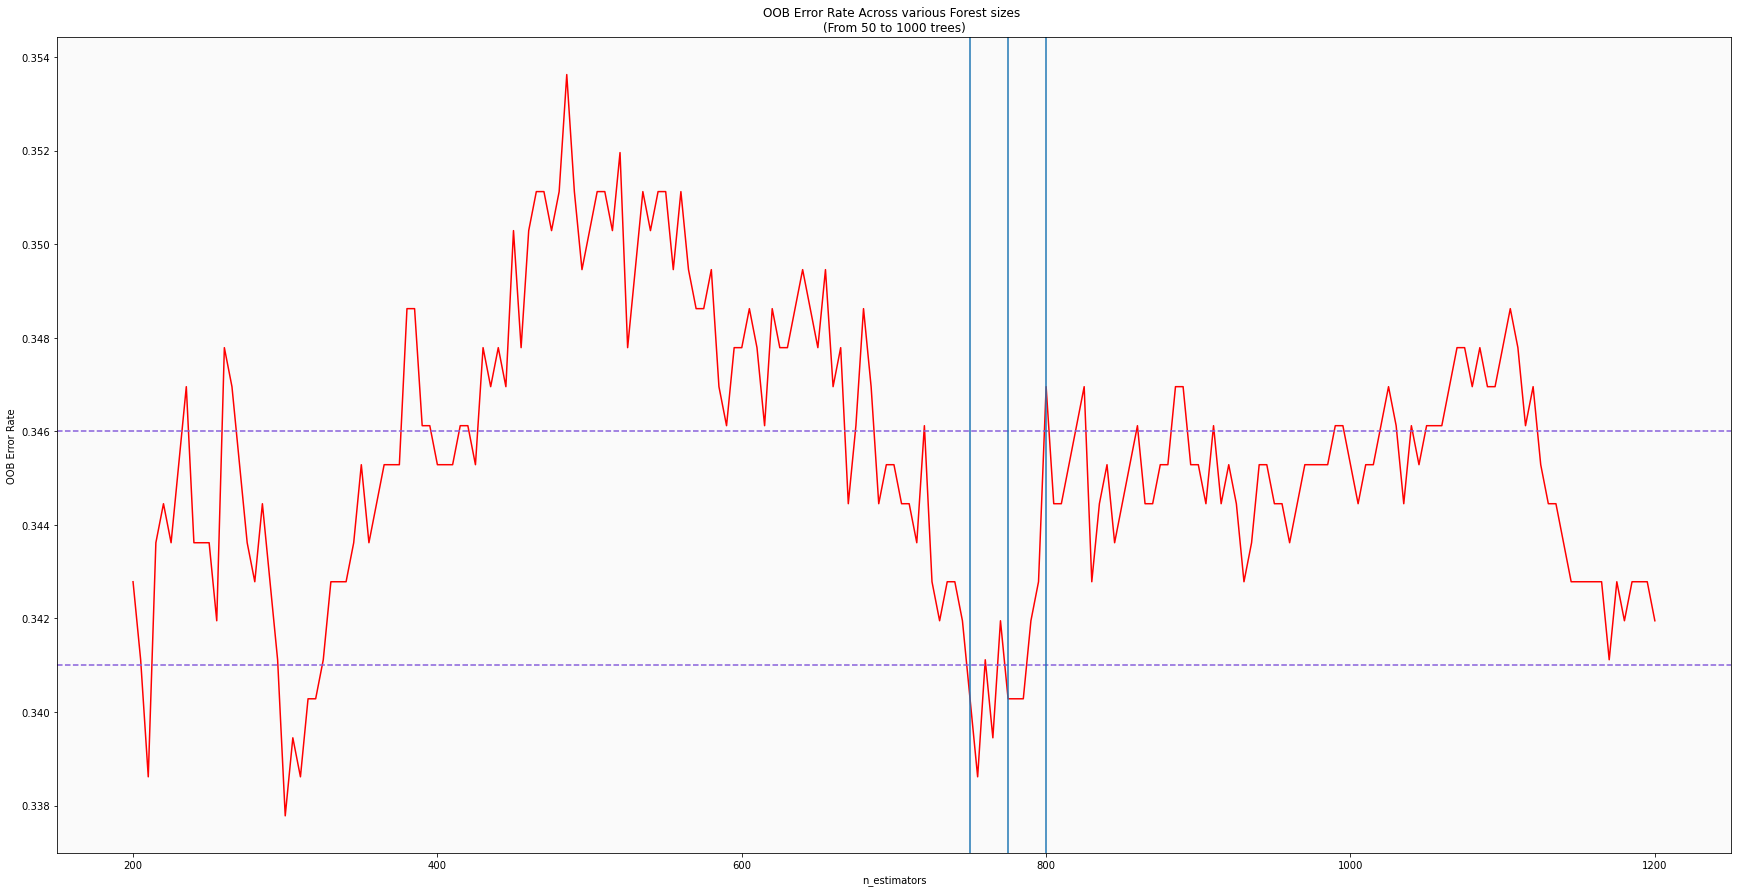

In [22]:
fig, ax = plt.subplots(figsize=(30, 15))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',color = 'red')
plt.axhline(0.346, color='#875FDB',linestyle='--')
plt.axhline(0.341, color='#875FDB',linestyle='--')
plt.axvline(750)
plt.axvline(775)
plt.axvline(800)
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 50 to 1000 trees)')

OOB Error rate for 750 trees is: 0.34028


Accuracy score : 0.7125


,3,4,5,6,7,8,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.78,0.639053,0.777778,0.0,0.7125,0.366139,0.695893
recall,0.0,0.0,0.78,0.750000,0.538462,0.0,0.7125,0.344744,0.712500
f1-score,0.0,0.0,0.78,0.690096,0.636364,0.0,0.7125,0.351077,0.700480
support,3.0,10.0,200.00,144.000000,39.000000,4.0,0.7125,400.000000,400.000000



Confusion matrix


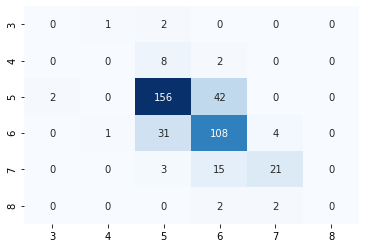

In [36]:
print('OOB Error rate for 750 trees is: {0:.5f}'.format(oob_series[775]))
print('\n')

model_rf.set_params(n_estimators=775, oob_score=False, bootstrap = False, warm_start=False)
model_rf.fit(x_train, y_train)
y_pred = model_rf.predict(x_test)

gather_metrics('Random Forest', y_test, y_pred, lst_quality)

### c. K nearest neighbours

#### KNN after removing outliers using z-score method

In [24]:
X_new = X.copy()
X_new['quality'] = dataset['quality']

for col in lst_cols :
    mean = X_new[col].mean()
    std = X_new[col].std()
    outliers_z = X_new[abs((X_new[col]-mean)/std) > 3]
    X_new.drop(outliers_z.index,axis=0,inplace=True)
print('Before and after outlier removal count : ', len(X), len(X_new))

scaler = StandardScaler()
X_new1 = scaler.fit_transform(X_new.drop('quality',axis=1))

k_min = 3
k_max = 50

accuracy_rate = []
error_rate = []

for i in range(k_min,k_max + 1):
    knn = KNeighborsClassifier(n_neighbors=i)
    score=cross_val_score(knn,X_new1,X_new['quality'],cv=10)
    accuracy_rate.append(score.mean())
    error_rate.append(1-score.mean())

Before and after outlier removal count :  1599 1431


Text(0, 0.5, 'Error Rate')

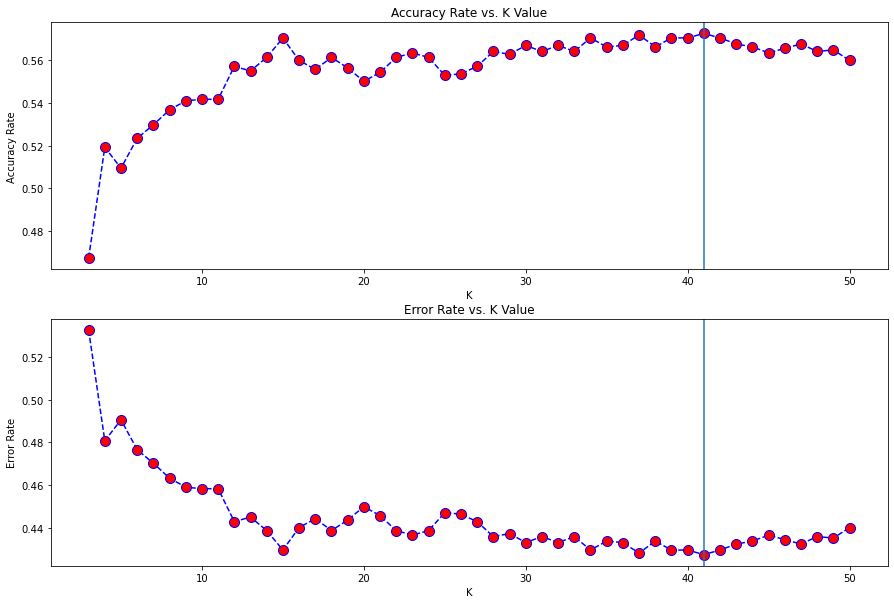

In [25]:
fig, axes = plt.subplots(2,1,figsize=(15,10))
axes = axes.ravel()
axes[0].plot(range(k_min,k_max + 1),accuracy_rate,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
# axes[0].vlines([20, 100], x=43, color='#875FDB',linestyle='--')
axes[0].axvline(41)
axes[0].set_title('Accuracy Rate vs. K Value')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Accuracy Rate')

axes[1].plot(range(k_min,k_max + 1),error_rate,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
axes[1].axvline(41)
axes[1].set_title('Error Rate vs. K Value')
axes[1].set_xlabel('K')
axes[1].set_ylabel('Error Rate')

WITH K=41


Accuracy score : 0.5698


,3,4,5,6,7,8,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.660256,0.518519,0.425000,0.0,0.569832,0.267296,0.539423
recall,0.0,0.0,0.691275,0.579310,0.369565,0.0,0.569832,0.273358,0.569832
f1-score,0.0,0.0,0.675410,0.547231,0.395349,0.0,0.569832,0.269665,0.553549
support,1.0,12.0,149.000000,145.000000,46.000000,5.0,0.569832,358.000000,358.000000



Confusion matrix


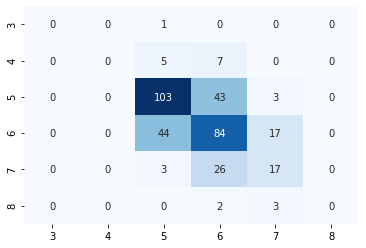

In [26]:
X_new1 = X_new.drop('quality',axis=1)
Y_new1 = X_new['quality']

x_train,x_test,y_train,y_test=train_test_split(X_new1,Y_new1,test_size=0.25, random_state=50)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

knn = KNeighborsClassifier(n_neighbors=41)
knn.fit(x_train,y_train)
y_pred = knn.predict(x_test)
    
print('WITH K=41')
print('\n')
gather_metrics('KNN - outlier z-score', y_test, y_pred, lst_quality)

#### KNN after removing outliers using IQR method

In [27]:
X_describe = X.describe()
X_new = X.copy()
X_new['quality'] = dataset['quality']

for col in lst_cols :
    Q1 = X_describe[col]["25%"]
    Q3 = X_describe[col]["75%"]
    IQR = Q3 - Q1
    outliers_iqr = X_new[(X_new[col] > Q3 + IQR * 1.5) | (X_new[col] < Q1 - IQR * 1.5)]
    X_new.drop(outliers_iqr.index,axis=0,inplace=True)
print('Before and after outlier removal count : ', len(X), len(X_new))
    
scaler = StandardScaler()
X_new1 = scaler.fit_transform(X_new.drop('quality',axis=1))
    
k_min = 3
k_max = 50

accuracy_rate = []
error_rate = []

for i in range(k_min,k_max + 1):
    knn = KNeighborsClassifier(n_neighbors=i)
    score=cross_val_score(knn,X_new1,X_new['quality'],cv=10)
    accuracy_rate.append(score.mean())
    error_rate.append(1-score.mean())

Before and after outlier removal count :  1599 1194


Text(0, 0.5, 'Error Rate')

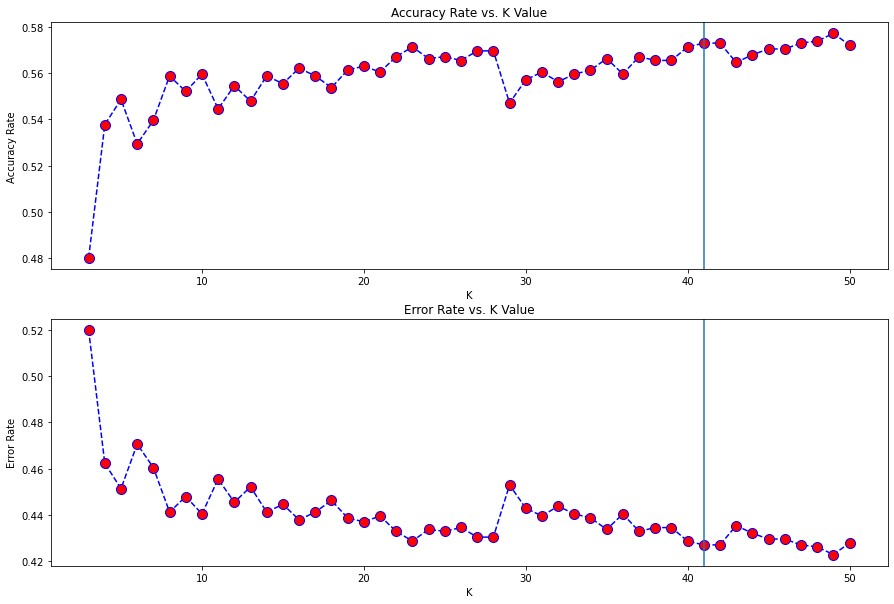

In [28]:
fig, axes = plt.subplots(2,1,figsize=(15,10))
axes = axes.ravel()
axes[0].plot(range(k_min,k_max + 1),accuracy_rate,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
axes[0].axvline(41)
axes[0].set_title('Accuracy Rate vs. K Value')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Accuracy Rate')

axes[1].plot(range(k_min,k_max + 1),error_rate,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
axes[1].axvline(41)
axes[1].set_title('Error Rate vs. K Value')
axes[1].set_xlabel('K')
axes[1].set_ylabel('Error Rate')


WITH K=41


Accuracy score : 0.5987


,3,4,5,6,7,8,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.671642,0.526316,0.692308,0.0,0.598662,0.315044,0.594867
recall,0.0,0.0,0.708661,0.677966,0.204545,0.0,0.598662,0.265195,0.598662
f1-score,0.0,0.0,0.689655,0.592593,0.315789,0.0,0.598662,0.266340,0.573267
support,3.0,5.0,127.000000,118.000000,44.000000,2.0,0.598662,299.000000,299.000000



Confusion matrix


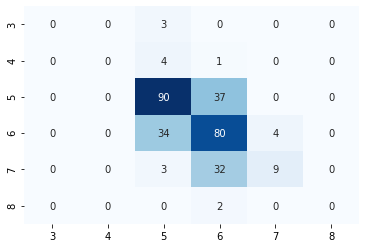

In [29]:
X_new1 = X_new.drop('quality',axis=1)
Y_new1 = X_new['quality']
x_train,x_test,y_train,y_test=train_test_split(X_new1,Y_new1,test_size=0.25, random_state=50)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

knn = KNeighborsClassifier(n_neighbors=41)
knn.fit(x_train,y_train)
y_pred = knn.predict(x_test)

print('WITH K=41')
print('\n')
gather_metrics('KNN - outlier IQR', y_test, y_pred, lst_quality)

### b.v. Naive bayes method

Accuracy score : 0.5675


,3,4,5,6,7,8,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.725714,0.509677,0.456522,0.0,0.5675,0.281986,0.590852
recall,0.0,0.0,0.635000,0.548611,0.538462,0.0,0.5675,0.287012,0.567500
f1-score,0.0,0.0,0.677333,0.528428,0.494118,0.0,0.5675,0.283313,0.577077
support,3.0,10.0,200.000000,144.000000,39.000000,4.0,0.5675,400.000000,400.000000



Confusion matrix


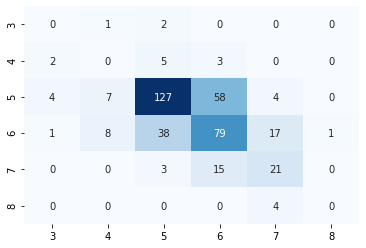

In [30]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25, random_state=50)

model = GaussianNB()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
gather_metrics('Naive bayes', y_test, y_pred, lst_quality)

## iii. Metrics comparison

### a. Accuracy Score

,Method,Accuracy score
0,LR - outlier z-score,0.583799
1,LR - outlier IQR,0.602007
2,Random Forest,0.712500
3,KNN - outlier z-score,0.569832
4,KNN - outlier IQR,0.598662
5,Naive bayes,0.567500


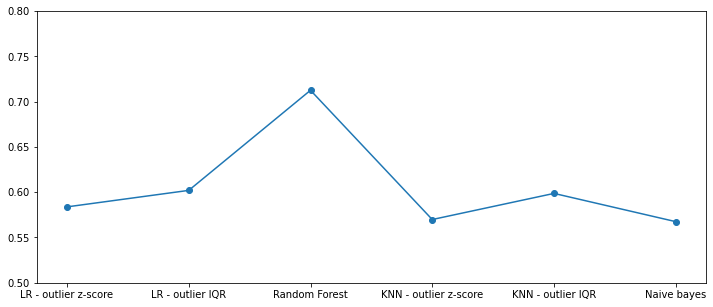

In [31]:
fig, axes = plt.subplots(figsize=(12, 5))
df = pd.DataFrame(test_output)
display(df)
axes.set_ylim([0.5, 0.8])
axes.plot(df['Method'],df['Accuracy score'], marker='o')

### b. Precision

     Precision


,Method,3,4,5,6,7,8
0,LR - outlier z-score,0.0,0.0,0.683544,0.527607,0.405405,0.0
1,LR - outlier IQR,0.0,0.0,0.673913,0.528986,0.636364,0.0
2,Random Forest,0.0,0.0,0.780000,0.639053,0.777778,0.0
3,KNN - outlier z-score,0.0,0.0,0.660256,0.518519,0.425000,0.0
4,KNN - outlier IQR,0.0,0.0,0.671642,0.526316,0.692308,0.0
5,Naive bayes,0.0,0.0,0.725714,0.509677,0.456522,0.0


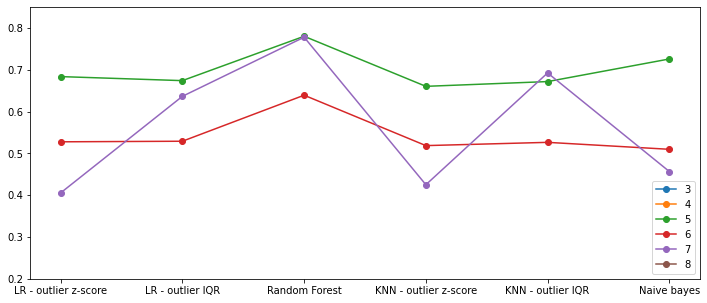

In [32]:
print('     Precision')
fig, axes = plt.subplots(figsize=(12, 5))
df = pd.DataFrame(test_precision)
display(df)
axes.set_ylim([0.2, 0.85])

for quality in lst_quality :
    axes.plot(df['Method'],df[quality], marker='o', label=quality)

plt.legend(loc="lower right")

### c. Recall

     Recall


,Method,3,4,5,6,7,8
0,LR - outlier z-score,0.0,0.0,0.724832,0.593103,0.326087,0.0
1,LR - outlier IQR,0.0,0.0,0.732283,0.618644,0.318182,0.0
2,Random Forest,0.0,0.0,0.780000,0.750000,0.538462,0.0
3,KNN - outlier z-score,0.0,0.0,0.691275,0.579310,0.369565,0.0
4,KNN - outlier IQR,0.0,0.0,0.708661,0.677966,0.204545,0.0
5,Naive bayes,0.0,0.0,0.635000,0.548611,0.538462,0.0


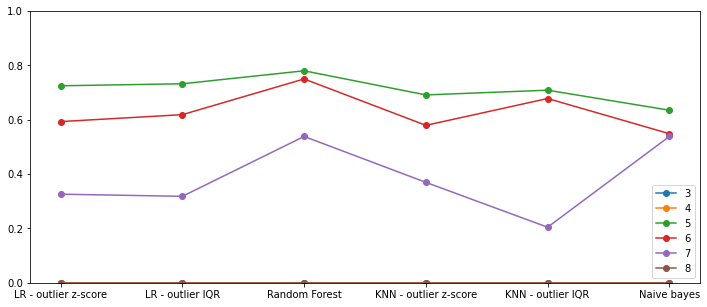

In [33]:
print('     Recall')
fig, axes = plt.subplots(figsize=(12, 5))
df = pd.DataFrame(test_recall)
display(df)
axes.set_ylim([0, 1])

for quality in lst_quality :
    axes.plot(df['Method'],df[quality], marker='o', label=quality)

plt.legend(loc="lower right")

### d. F1-score

     F1-score


,Method,3,4,5,6,7,8
0,LR - outlier z-score,0.0,0.0,0.703583,0.558442,0.361446,0.0
1,LR - outlier IQR,0.0,0.0,0.701887,0.570312,0.424242,0.0
2,Random Forest,0.0,0.0,0.780000,0.690096,0.636364,0.0
3,KNN - outlier z-score,0.0,0.0,0.675410,0.547231,0.395349,0.0
4,KNN - outlier IQR,0.0,0.0,0.689655,0.592593,0.315789,0.0
5,Naive bayes,0.0,0.0,0.677333,0.528428,0.494118,0.0


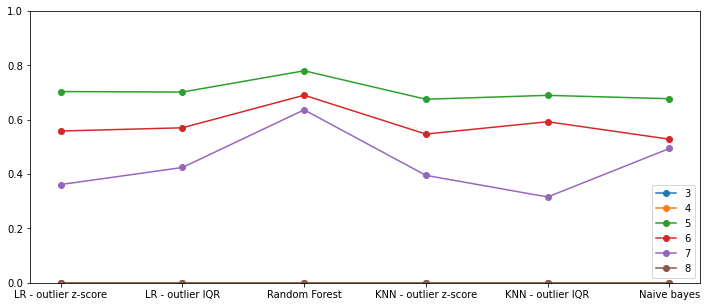

In [34]:
print('     F1-score')
fig, axes = plt.subplots(figsize=(12, 5))
df = pd.DataFrame(test_f1score)
display(df)
axes.set_ylim([0, 1])

for quality in lst_quality :
    axes.plot(df['Method'],df[quality], marker='o', label=quality)

plt.legend(loc="lower right")